In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
#%matplotlib notebook
from scipy.fft import fft

In [2]:
def mypgmread(filename):
    with open(filename,'rb') as f:#write binary olarak dosyayı açtım, bu sayede pgm dosyasına binary yazabiliyorum.
        magic_word = f.readline().strip().decode() #Magicword. Strip metodu ile stringin başında ve sonundaki boşlukları kaldırıyoruz.
        comment = '#'
        f_content = f.readline().decode()
        while(f_content[0] == '#'):#Yorum satırlarını ayırt etmek için.
            f_content = f.readline()
#split metodu default olarak stringi boşluklardan ayırır. kelime kelime listeler.
        [width,height] = f_content.split()
        width = int(width)
        height = int(height)
        maxval = f.readline().decode()
        maxval = int(maxval)
        #print(magic_word)
        #print(f'width: {width}, height: {height}')
       # print(maxval)
        i = 0
        j = 0
        imgValue = [[0 for i in range(width)] for j in range(height)]
        byte = f.read(1)
        counter = 0
        while(counter != width*height):
            #print(f'i = {i}\nj = {j}')
            imgValue[i][j] = ord(byte)
            #print(f'byte {ord(byte)}')
            j += 1
            counter += 1
            if(j == width):
                i += 1
                j = 0
            byte = f.read(1)
    return magic_word,width,height,maxval,imgValue

In [3]:
def my2Dfft(data,width,height):
    data_fft = np.array([[0 for i in range(width)] for j in range(height)],dtype=np.complex_)
    last_data_fft = np.array([[0 for i in range(width)] for j in range(height)],dtype=np.complex_)
    for i in range(height):
        data_fft[i] = np.fft.fft(data[i])

    for j in range(width):
        last_data_fft[:,j] = np.fft.fft(data_fft[:,j])
    
    return last_data_fft
    

In [4]:
def normalization(data):
    height = len(data)
    width = len(data[0])
    normalized = np.array([[0 for i in range(width)] for j in range(height)])
    minimum = np.min(data)
    maximum = np.max(data)
    normalized = 255*(data - minimum)/(maximum-minimum)
    return normalized        
    

In [5]:
def myShiftCenter(data,width,height):
    temp = np.array([[0 for i in range(width)] for j in range(height)])
    for i in range(height):
        for j in range(width):
            temp[i][j] = data[i][j] * (-1)**(i+j)
    return temp

In [6]:
def my2Difft(data,width,height):
    temp = np.array([[0 for i in range(width) for j in range(height)]])
    temp = my2Dfft(np.conjugate(data),width,height)
    
    
    return temp
    

500
800


Text(0.5, 1.0, 'Original Image')

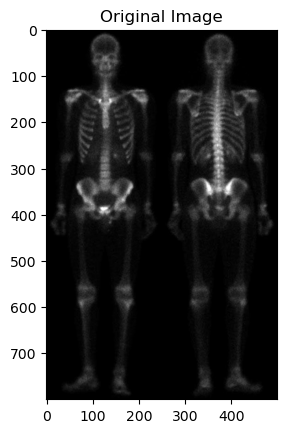

In [8]:
mw,width,height,maxval,img = mypgmread("fig0334.pgm")
plt.imshow(img,cmap="gray",vmin=0,vmax=255)
print(width)
print(height)
plt.title("Original Image")

In [9]:
def myLaplacianFreq(data,mode,c): #mode = 1 ise diagonal maske, mode=0 ise köşeler sıfır olan maske kullanılır.
    height,width = np.array(data).shape
    print(f'width:{width},height:{height}')
    if mode==1:
        mask = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
    else:
        mask = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
    P = height
    Q = width
    maskPadded = np.pad(mask,((0,height-len(mask)),(0,width-len(mask))),'constant',constant_values=(0,0))
    print(f'maskPadded: {maskPadded.shape}')
    maskFreq = my2Dfft(maskPadded,Q,P)
    #dataPadded = np.pad(data,((0,2),(0,2)),'constant',constant_values=(0,0))
    dataFreq = my2Dfft(data,Q,P)
    
    filtered = dataFreq*maskFreq
    filteredTime = my2Difft(filtered,Q,P)
    laplacian = c*filteredTime
    return laplacian

width:500,height:800
maskPadded: (800, 500)


Text(0.5, 1.0, 'Laplacian')

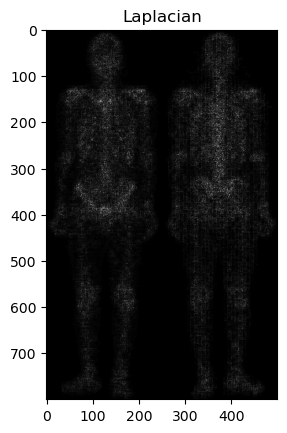

In [10]:
newLaplacian = abs(myLaplacianFreq(img,1,1))
newLaplacianNormalized = normalization(newLaplacian)
plt.imshow(newLaplacianNormalized,cmap="gray",vmin=0,vmax=255)
plt.title("Laplacian")

### Normalize etmeme rağmen gri görüntüyü elde edemedim.

Text(0.5, 1.0, 'Added laplacian')

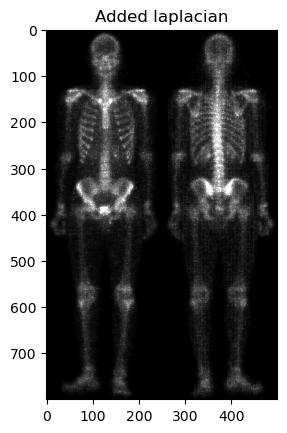

In [11]:
gxy = img+newLaplacianNormalized
plt.imshow(gxy,cmap="gray",vmin=0,vmax=255)
plt.title("Added laplacian")

### Laplasyen görüntüsünü orijinal görüntüye ekleyince detayların daha açığa çıktığı yukarıda görülmektedir.

In [12]:
def mySobelFreq(data):
    height,width = np.array(data).shape
    sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    
    sobel_x_padded = np.pad(sobel_x,((0,height-len(sobel_x)),(0,width-len(sobel_x))),'constant',constant_values=(0,0))
    sobel_y_padded = np.pad(sobel_y,((0,height-len(sobel_y)),(0,width-len(sobel_y))),'constant',constant_values=(0,0))
    
    sobel_x_freq = my2Dfft(sobel_x_padded,width,height)
    sobel_y_freq = my2Dfft(sobel_y_padded,width,height)
    
    imgFreq = my2Dfft(data,width,height)
    
    processed_x_freq = imgFreq*sobel_x_freq
    processed_y_freq = imgFreq*sobel_y_freq
    
    processed_x = my2Difft(processed_x_freq,width,height)
    processed_y = my2Difft(processed_y_freq,width,height)
    
    processed_img = abs(processed_x)+abs(processed_y)
    processed_img_n = normalization(processed_img)
    return processed_img_n
    
## Sobelin x ve y yönündeki komponentleri için yukarıda kodlar yazılmıştır. İkisi içinde aynı işlemler uygulandı.

Text(0.5, 1.0, 'Sobel filtresi uygulanmış görüntü')

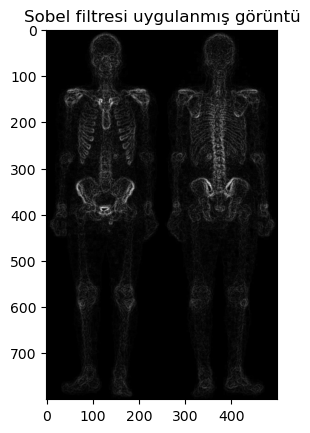

In [14]:
sobelImg = mySobelFreq(img)
plt.imshow(sobelImg,cmap="gray",vmin=0,vmax=255)
plt.title("Sobel filtresi uygulanmış görüntü")

### Sobel filtresi kenarları bulmaya yarar. Yukarıda da görüntünün kenarları detayları açığa çıkarılmıştır.

In [15]:
def mySmoothingFreq(data):
    height,width = np.array(data).shape
    mask = np.array([[1 for i in range(5)] for j in range(5)])/25
    mask_padded = np.pad(mask,((0,height-5),(0,width-5)),'constant',constant_value=(0,0))
    
    mask_f = my2Dfft(mask_padded,width,height)
    data_f = my2Dfft(data,width,height)
    g_f = data_f*mask_f
    g = abs(my2Difft(g_f,width,height))
    g_n = normalization(g)
    return g_n
    

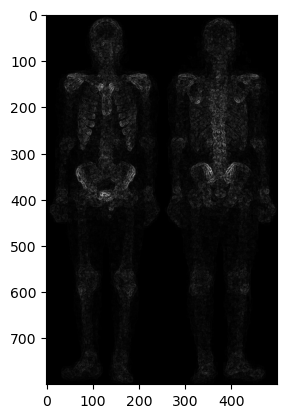

In [167]:
smoothedSobel = mySobelFreq(sobelImg)
plt.imshow(smoothedSobel,cmap="gray",vmin=0,vmax=255)

### Yukarıda sobel görüntüsünün yumuşatılmış hali görülmektedir. Buradaki görüntüler kitaptakine göre daha karanlık çıkmıştır.

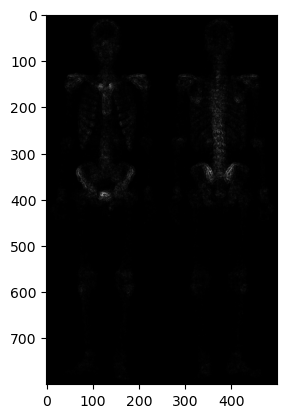

In [168]:
mask_image = smoothedSobel*gxy
mask_image_n = normalization(mask_image)
plt.imshow(mask_image_n,cmap="gray",vmin=0,vmax=255)

### Yumuşatılmış sobel ile added laplacian görüntüsünün çarpımı yukarıdaki maskeyi vermiştir.

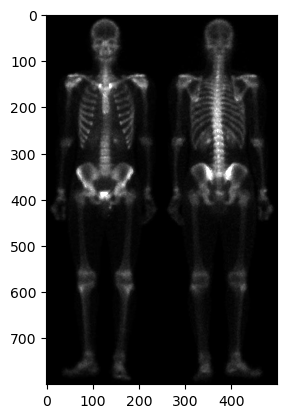

In [174]:
sharpened_img = img+mask_image_n
plt.imshow(sharpened_img,cmap="gray",vmin=0,vmax=255)

### Maske normal görüntüye eklenince yukarıdaki gibi detayların açığa çıktığı görüntü elde edilmiştir.

In [169]:
def myImgCorrelation(width,height,img,m,n):
    mask = np.array([[1 for i in range(n)] for j in range(m)])
    temp = img
    a=(m-1)/2
    b=(n-1)/2
    filteredImg = np.array([[0 for i in range(width)] for j in range(height)])
    
    #Matrisi m ve n değerlerine göre 0 lar ile genişletiyoruz.
    new_column = np.array([0 for i in range(height)]).reshape(height,1)#oluşturulan vektörü sütun vektörü haline getiriyorum.
    for i in range(int(b)*2):#matrisin her tarafı sıfırlarla kaplanması için sütundan ve satırdan b değerinin 2 katı kadar koymalıyız
        temp = np.hstack((temp, new_column))
    
    new_width = len(temp[0])#yukarıda matrise sütun eklendiği için matrisin genişliği değişti. Bu yeni genişliği elde ediyorum.
    new_row = np.array([0 for j in range(new_width)])#Yeni genişlik uzunluğunda 0 satır vektörünü oluşturuyorum.
    for j in range(int(a)*2):#Aynı şekilde matrisin hem üstüne hem altına 0'lar gelmesi için a*2 yapıyorum.
        temp = np.vstack((temp,new_row))
    #Yukarıda eklenen satır ve sütunlar matrisin altına ve sağına eklendiği için tam istediğimiz forma henüz ulaşmamıştır. Bunu
    #istediğimiz forma sokmak için elimizdeki asıl değerleri hem alta hem de sağa doğru o yönde eklediğimiz vektör sayısının
    #yarısı kadar kaydırmamız gerekiyor. Örneğin sağa 2 ve alta 2 vektör eklediysek 1 sağa 1 de aşağı kaydırarak asıl orijinal
    #matrisi merkez kısma yerleştirmiş ve etrafını sıfırlarla kaplamış oluyoruz.
    for i in range(int(a)):
        temp = np.roll(temp, shift=1, axis=0)
        temp = np.roll(temp, shift=1, axis=1)
        
    for i in range(height):
        for j in range(width):
            sum = 0
            for r in range(0,m,1):
                for s in range(0,n,1):
                    sum = sum + mask[r][s]*temp[i+r][j+s]#Artık elimizde padding yapılmış bir matris olduğu için maskeyi
                    #özel şartlar koymadan genişletilmiş matris üstünde gezdirip average işlemini yapabiliriz.
            filteredImg[i][j] = sum/9
    return filteredImg
                    

In [175]:
def myImageGamma(width,height,img,c,gamma):
    newImg = np.array([[0 for i in range(width)] for j in range(height)],dtype=float)
    for i in range(height):
        for j in range(width):
            newImg[i][j] = c*img[i][j]**gamma
    return newImg

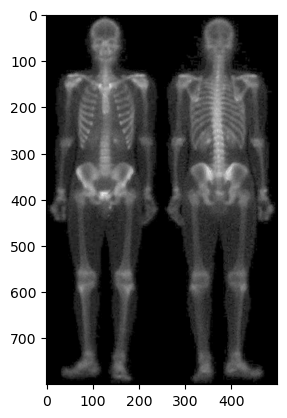

In [182]:
final_image = myImageGamma(width,height,sharpened_img,1,0.4)
final_image_n = normalization(final_image)
plt.imshow(final_image_n,cmap="gray",vmin=0,vmax=255)

### görüntüye gamma fonksiyonu uygulanarak en son görüntü elde edilmiştir.